In [160]:
import pandas as pd
import tensorflow as tf
import keras
from keras import layers as ls
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
import seaborn as sns
from scipy import stats
import xgboost as xgb
import joblib

In [122]:
df = pd.read_csv("forestfires.csv")
df.columns

Index(['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH',
       'wind', 'rain', 'area'],
      dtype='object')

In [123]:
# Mapping of days to numeric values
day_mapping = {
    'mon': 1,
    'tue': 2,
    'wed': 3,
    'thu': 4,
    'fri': 5,
    'sat': 6,
    'sun': 7
}

# Map the days to numeric values
df['day'] = df['day'].map(day_mapping)

In [124]:
df['TempAndFFMC'] = df['temp'] / df['FFMC']

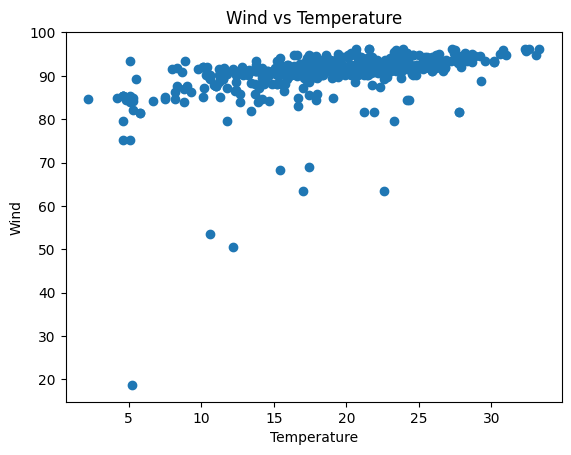

In [159]:
plt.scatter(df['temp'], df['FFMC'])
plt.xlabel('Temperature')
plt.ylabel('Wind')
plt.title("Wind vs Temperature")
plt.show()

In [126]:
df['area'] = np.log10(df['area'] + 1)
df['area'] = np.sqrt(df['area'])  # Requires all data to be positive

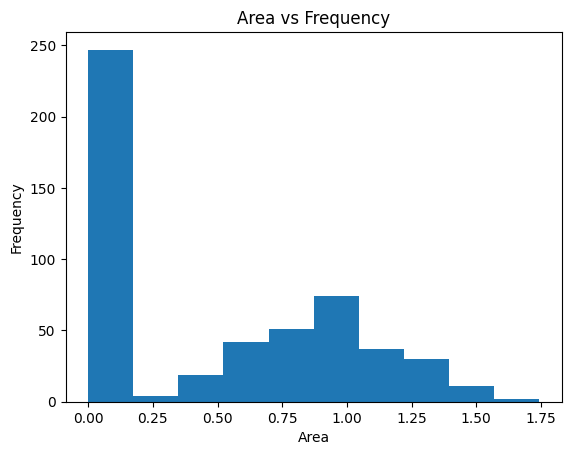

In [158]:
plt.hist(df['area'], bins = 10)
plt.xlabel("Area")
plt.ylabel("Frequency")
plt.title("Area vs Frequency")
plt.show()

In [128]:
plt.scatter(df['temp'], df['goal'])
plt.xlabel('FFMC')
plt.ylabel('Goal')
plt.show()

KeyError: 'goal'

In [129]:
threshold = 0.5
df['goal'] = df['area'] > threshold
df['goal'] = df['goal'].astype(int)

In [130]:
month_to_season = {
    'jan': 'Winter',
    'feb': 'Winter',
    'mar': 'Spring',
    'apr': 'Spring',
    'may': 'Spring',
    'jun': 'Summer',
    'jul': 'Summer',
    'aug': 'Summer',
    'sep': 'Autumn',
    'oct': 'Autumn',
    'nov': 'Autumn',
    'dec': 'Winter'
}

# Map the months to seasons
df['season'] = df['month'].map(month_to_season)

# Define one-hot encoding vectors for each season
season_vectors = {
    'Spring': [1, 0, 0, 0],
    'Summer': [0, 1, 0, 0],
    'Autumn': [0, 0, 1, 0], 
    'Winter': [0, 0, 0, 1]
}

# Create the season_encoded column with vectors
df['season_encoded'] = df['season'].map(season_vectors)

df.head(2)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,TempAndFFMC,goal,season,season_encoded
0,7,5,mar,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,0.095128,0,Spring,"[1, 0, 0, 0]"
1,7,4,oct,2,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0.198675,0,Autumn,"[0, 0, 1, 0]"


In [131]:
print(len(df))
print(len(df) / 7)

517
73.85714285714286


In [178]:
#season_encoded_df = pd.DataFrame(df['season_encoded'].tolist())
X = pd.concat([df[['ISI', 'temp', 'DC', 'ISI', 'RH', 'wind','TempAndFFMC']]], axis=1).values # , season_encoded_df
Y = df['goal']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15)
print()
print(X_test.shape)


(78, 7)


# DL Model

In [179]:
inputs = ls.Input(shape=(7, ))

x = ls.Dense(64, activation='relu')(inputs)
x = ls.Dense(32, activation='relu')(x)
x = ls.Dense(16, activation='relu')(x)

prediction = ls.Dense(1, activation='sigmoid')(x)

model2 = keras.Model(inputs=inputs, outputs=prediction, name="forest_area_predictor")

model2.summary()

Model: "forest_area_predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,137 (12.25 KB)

 Trainable params: 3,137 (12.25 KB)

 Non-trainable params: 0 (0.00 B)

In [180]:
model2.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
    #oijsfcn
)

In [181]:
#X_train, X_test, y_train, y_test = train_test_split(df[['ISI', 'temp', 'DC', 'ISI', 'RH', 'wind','TempAndFFMC']], df['goal'])
#X_train = X_train.to_numpy()  # or use .values
#y_train = y_train.to_numpy()  # or use .values

In [182]:
history = model2.fit(X_train, y_train, batch_size=16, epochs=300)
predictions = model2.predict(X_test)

Epoch 1/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4679 - loss: 10.9844
Epoch 2/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5276 - loss: 1.1721 
Epoch 3/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4819 - loss: 1.1289 
Epoch 4/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5253 - loss: 0.7504 
Epoch 5/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4966 - loss: 0.7798 
Epoch 6/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5674 - loss: 0.7774 
Epoch 7/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4869 - loss: 0.8742 
Epoch 8/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 0.5309 - loss: 0.7319
Epoch 9/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5285 - loss: 1.4254 
Epoch 10/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - accuracy: 0.4942 - loss: 0.9937
Epoch 11/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5318 - loss: 0.7234 
Epoch 12/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/s

In [183]:
threshold_dlmodel = 0.5
predictions = ((predictions >= threshold_dlmodel).astype(int)).flatten()
print(predictions)
print(y_test)

[0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0]
214    1
494    1
74     0
326    0
88     0
      ..
100    0
35     0
109    0
243    0
504    1
Name: goal, Length: 78, dtype: int32


In [184]:
print(np.mean(predictions == y_test))

0.5897435897435898


In [196]:
joblib.dump(model2, 'model2.joblib')

['model2.joblib']

In [185]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

prediction = log_reg.predict(X_test)

c:\Users\lordw\OneDrive\Documents\Hackathons\HowdyHack2024\tamuhack24\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [186]:
print(prediction.flatten())
print([i for i in y_test])

[0 1 0 1 1 0 0 0 0 1 0 1 1 0 1 0 1 0 1 0 0 1 0 0 1 1 1 1 0 0 0 1 1 0 0 0 0
 0 1 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 0 1 1 0 1 0 1 0 0 1 0 0 0 0 0 1 1 0 1
 1 1 1 1]
[1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]


In [188]:
model_xgb = xgb.XGBClassifier(objective='binary:logistic', n_estimators=200, max_depth=40, learning_rate=0.4)

model_xgb.fit(X_train, y_train)

predictions_xgb = model_xgb.predict(X_test)

print(predictions_xgb)
print([i for i in y_test])
print(np.mean(predictions_xgb == y_test))

[1 0 1 1 0 0 1 0 0 1 0 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 0 1 1 1 0 1 1 0 0 0
 0 1 0 1 0 0 0 0 1 1 0 1 1 0 1 1 0 0 1 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 0 1 0
 0 0 1 1]
[1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]
0.5256410256410257


In [189]:
joblib.dump(model_xgb, "xgb.joblib")

['xgb.joblib']

In [192]:
model_rf = RandomForestClassifier(max_depth=30, n_estimators=100)
model_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=30)

In [193]:
predictions_rf = model_rf.predict(X_test)
print(predictions_rf)
print([i for i in y_test])
print(np.mean(predictions_rf == y_test))

[1 0 1 0 1 0 1 1 0 1 1 1 0 1 0 1 0 0 1 1 1 0 0 1 0 1 1 0 1 1 1 0 1 1 0 0 0
 0 1 0 1 0 0 0 0 1 1 1 1 1 0 0 1 0 0 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 1 0 1 0
 0 0 1 1]
[1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]
0.5


In [195]:
base_models = [
    ('rf', model_rf),
    ('xgb', model_xgb),
    ('mlp', model2)
]

# Define meta-model
meta_model = LogisticRegression()

# Create stacking model
voting_model = VotingClassifier(
    estimators=base_models,
    voting='hard'
)

votes = voting_model.fit(X_train, y_train)

predictions = voting_model.predict(X_test)

accuracy = np.mean(predictions == y_test)

ValueError: The estimator Functional should be a classifier.